## Data Underfitting and Overfitting

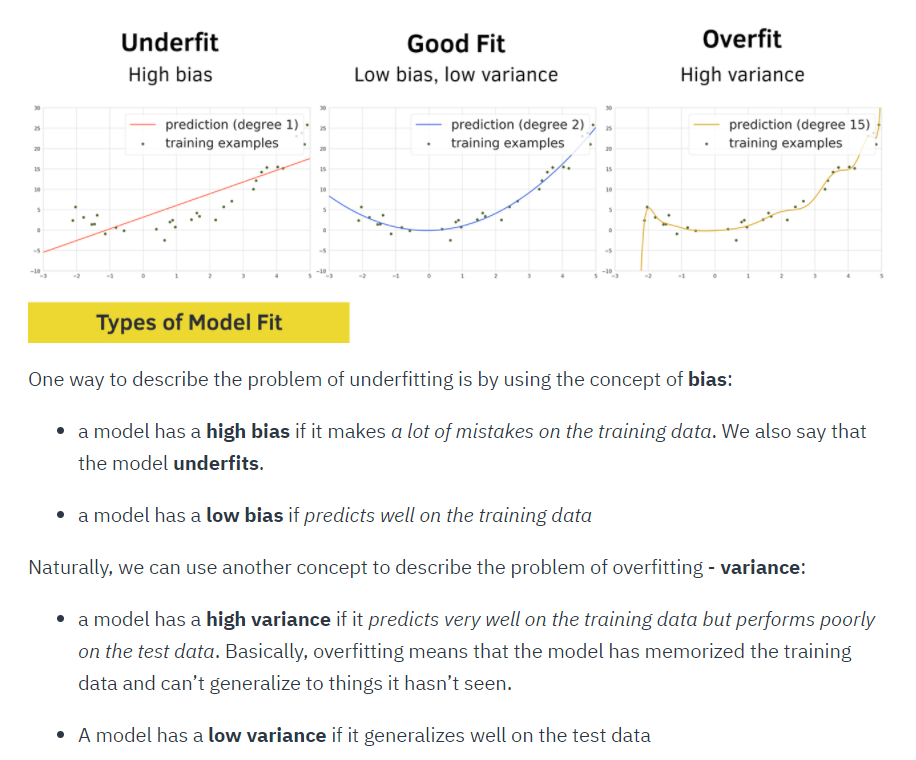

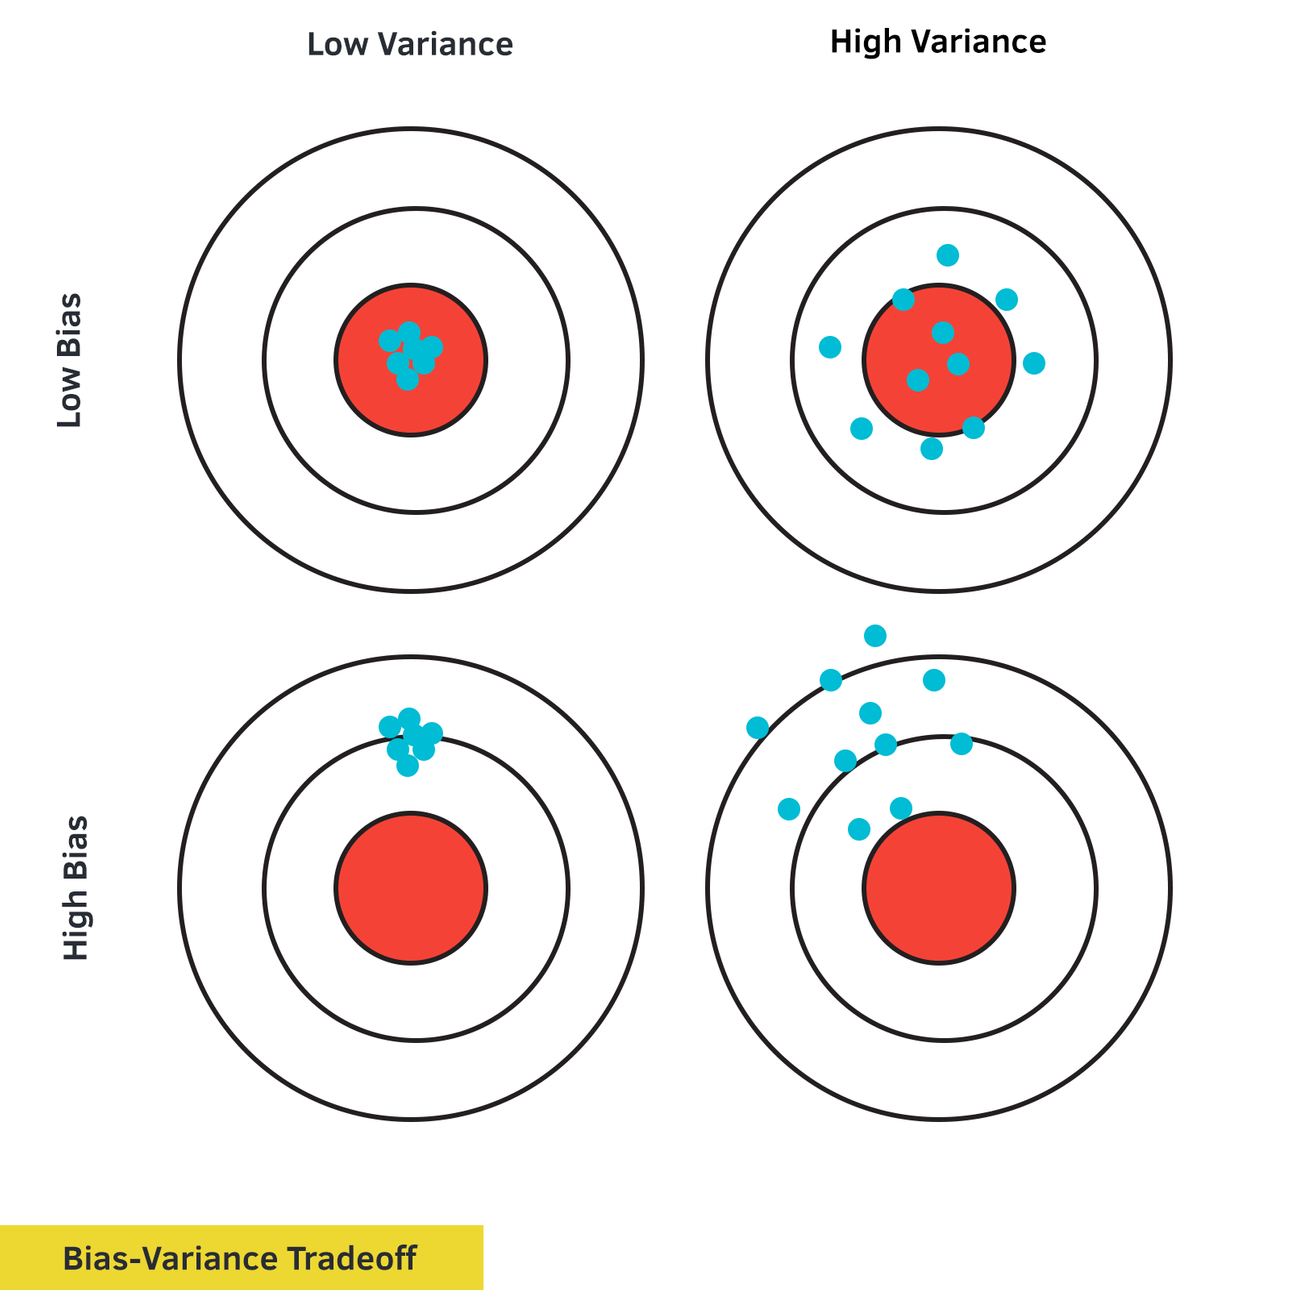

Problems to overcome:
- Data has no predictive power
- Model is too simple to make good predctions
- Data brings the Curse of dimensionality
- Model is too complex

In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np

In [2]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


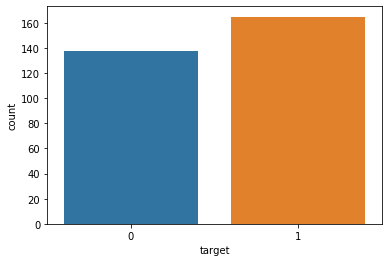

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df.target)

In [6]:
df.isnull().values.any()

False

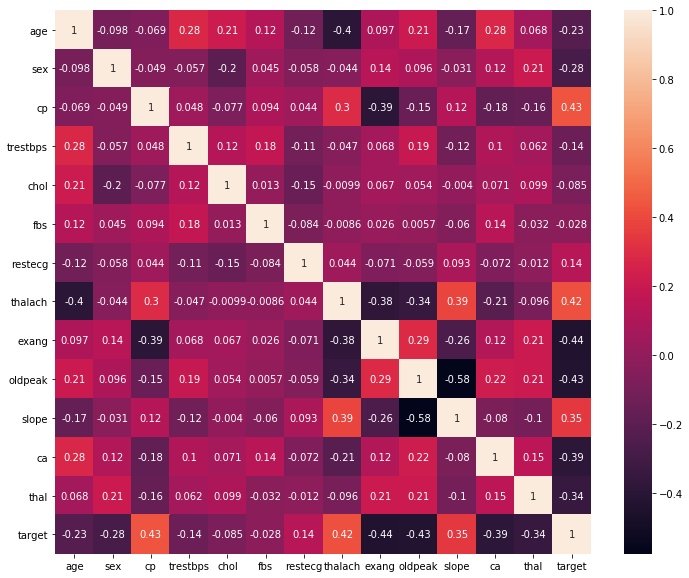

In [21]:
from matplotlib import rcParams
rcParams["figure.figsize"] = 12, 10

sns.heatmap(df.corr(),annot=True)

In [24]:
important_vals = df.corr().sort_values('target', ascending=False).index.values
important_vals

array(['target', 'cp', 'thalach', 'slope', 'restecg', 'fbs', 'chol',
       'trestbps', 'age', 'sex', 'thal', 'ca', 'oldpeak', 'exang'],
      dtype=object)

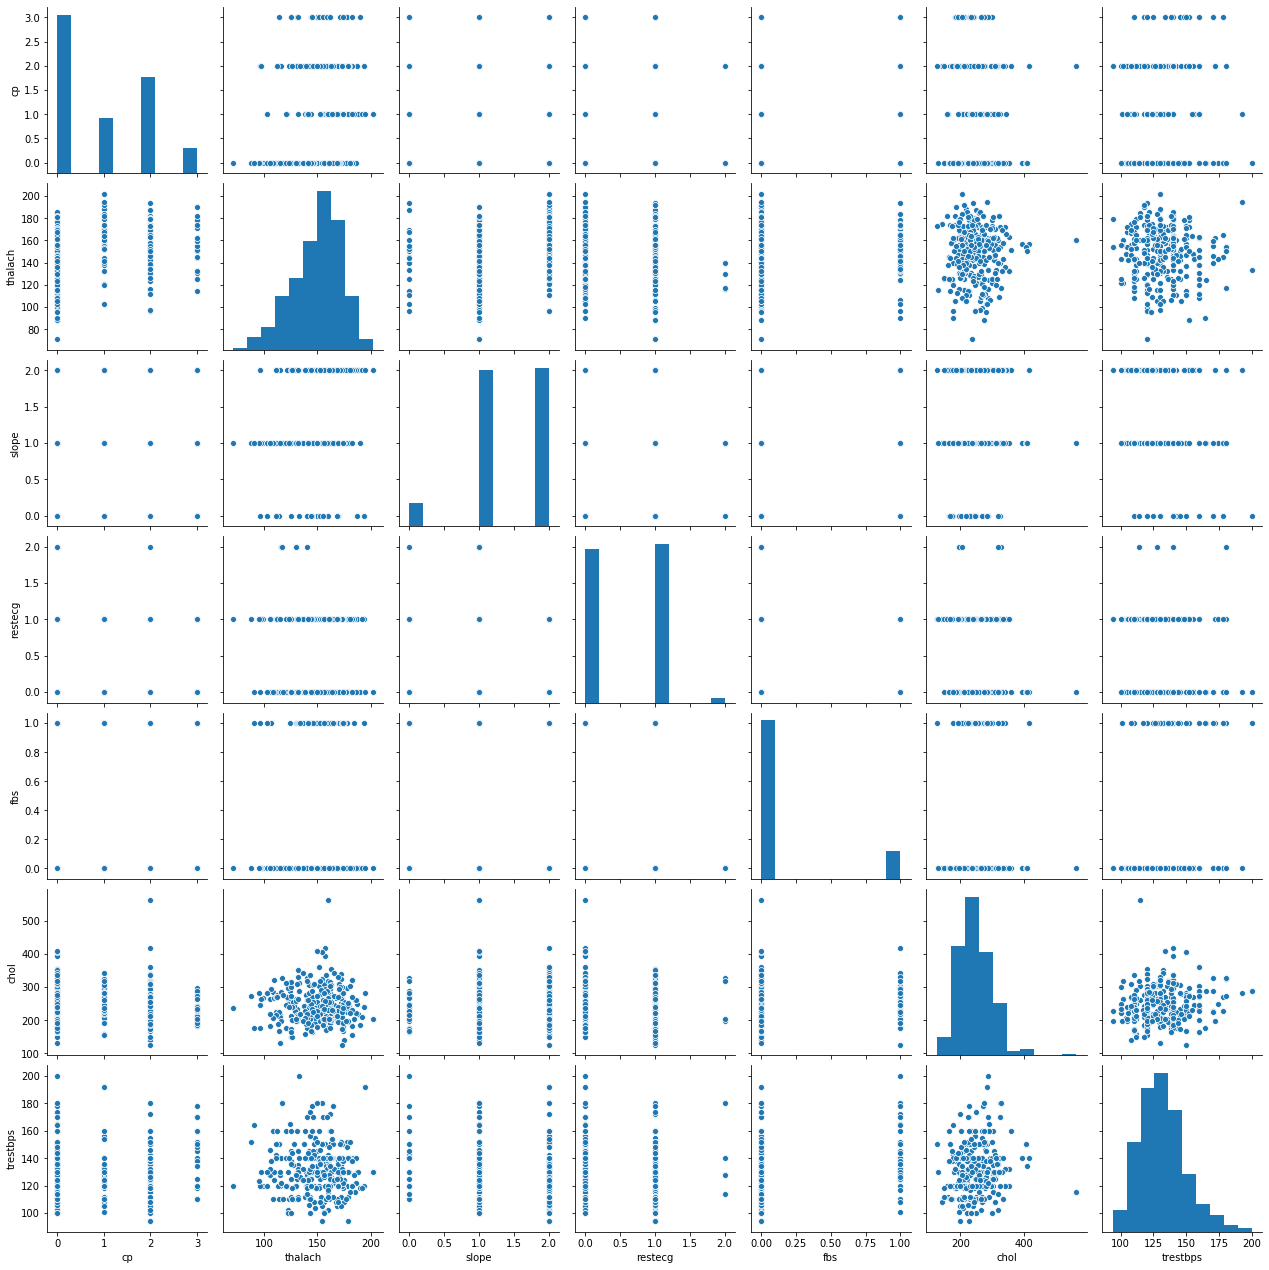

In [25]:
sns.pairplot(df[important_vals[1:8]])

### Data with no predictive power

In [48]:
from sklearn.model_selection import train_test_split

X = df[['trestbps']]
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)

In [49]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as ly

model = Sequential([
    ly.Dense(32, activation="relu", input_shape=[X_train.shape[1]]),
    ly.Dense(16, activation="relu"),
    ly.Dense(1)
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
his = model.fit(X_train, y_train, shuffle=True, epochs=100, validation_split=0.2, batch_size=32, verbose=0)

No handles with labels found to put in legend.


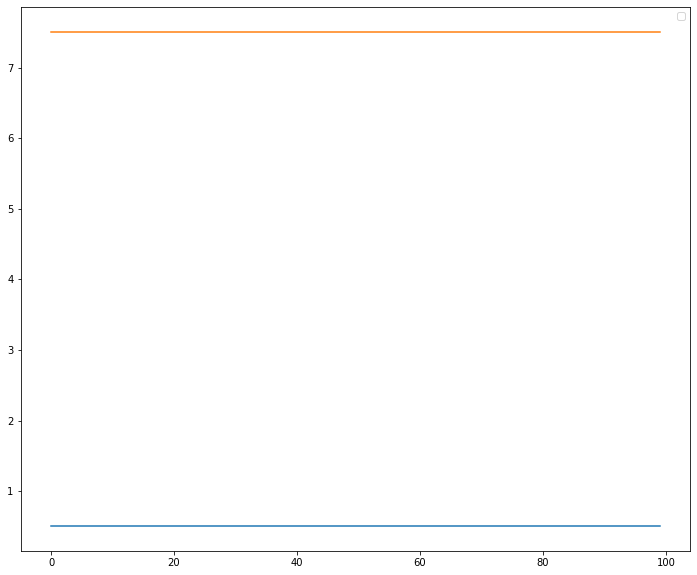

In [51]:
acc = his.history["accuracy"]
loss = his.history["loss"]
plt.plot(acc)
plt.plot(loss)
plt.legend()
plt.show()

So the model is flatlining. This is expected as the feature that are used has no predictive power.

#### Fix:
Change to informative features.

In [52]:
X = pd.get_dummies(df[["oldpeak", "cp"]], columns=["cp"])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)

No handles with labels found to put in legend.


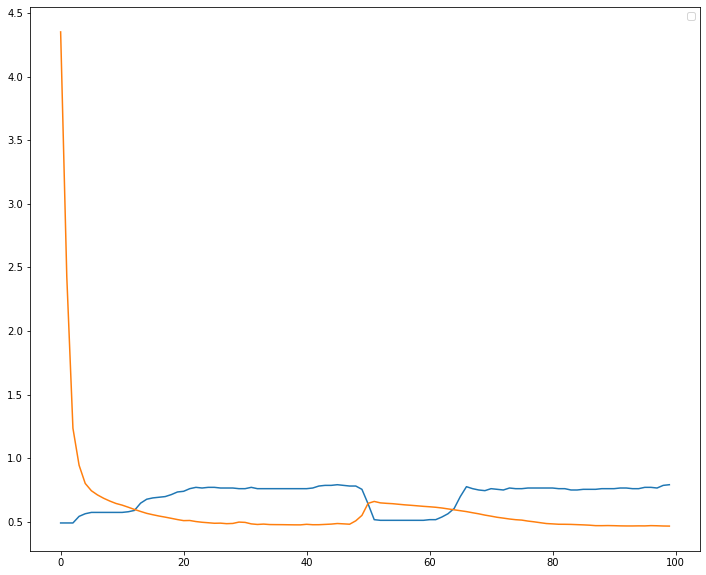

In [53]:
model = Sequential([
    ly.Dense(32, activation="relu", input_shape=[X_train.shape[1]]),
    ly.Dense(16, activation="relu"),
    ly.Dense(1)
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
his = model.fit(X_train, y_train, shuffle=True, epochs=100, validation_split=0.2, batch_size=32, verbose=0)
acc = his.history["accuracy"]
loss = his.history["loss"]
plt.plot(acc)
plt.plot(loss)
plt.legend()
plt.show()

### Underpowered model

Text(0.5, 1.0, 'Age vs Maximum Heart Rate')

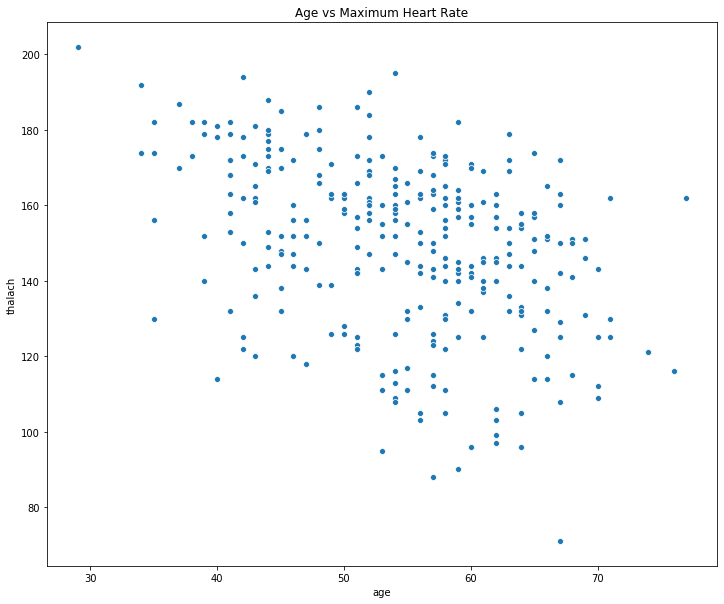

In [54]:
sns.scatterplot(df.age, df.thalach)
plt.title("Age vs Maximum Heart Rate")

In [91]:
from sklearn.preprocessing import MinMaxScaler

s = MinMaxScaler()

X = s.fit_transform(df[["age"]])
y = s.fit_transform(df[["thalach"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2020)

In [92]:
X_train.shape, X_test.shape

((242, 1), (61, 1))

In [93]:
model = Sequential([
    ly.Dense(1, activation="linear", input_shape=[X_train.shape[1]])
])
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

In [94]:
his = model.fit(X_train, y_train, shuffle=True, epochs=500, validation_split=.2, batch_size=32, verbose=0)

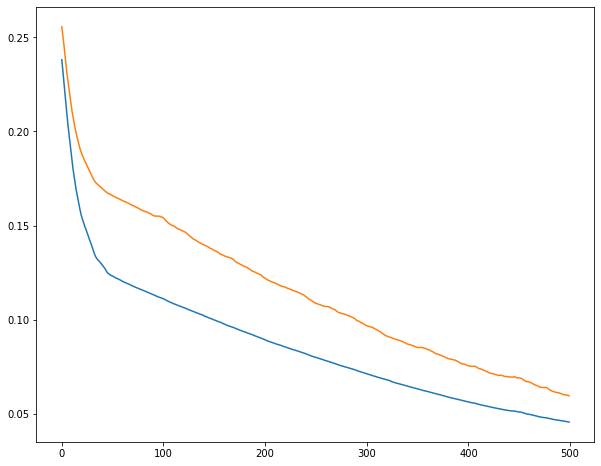

In [95]:
def show_plot_lin(h):
    his = pd.DataFrame(h.history)
    epoch = h.epoch
    loss = his["loss"]
    val_loss = his["val_loss"]
    plt.figure(figsize = (10, 8))
    plt.plot(epoch, loss)
    plt.plot(epoch, val_loss)
    plt.show()
    
show_plot_lin(his)

In [96]:
his.history["val_mse"][-1]

0.05960753560066223

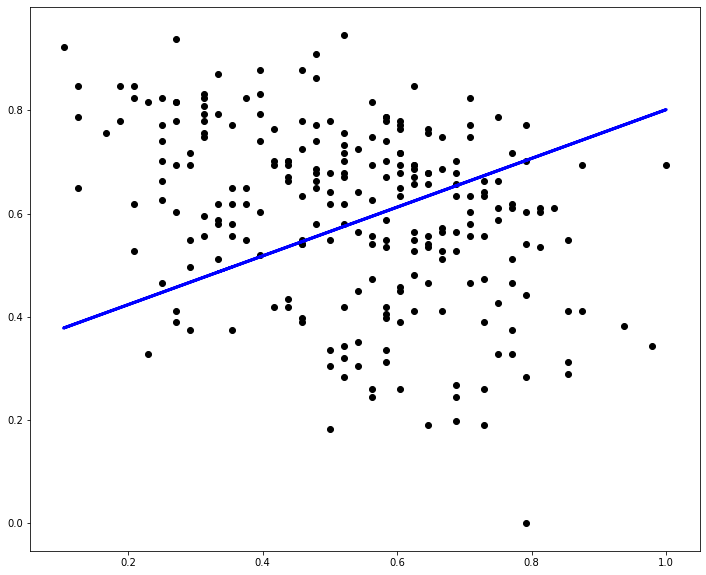

In [97]:
plt.scatter(X_train, y_train, color="black")
plt.plot(X_train, model.predict(X_train), color="blue", linewidth=3)

#### Fix
More powerful model

In [98]:
model = Sequential([
    ly.Dense(64, activation="relu", input_shape=[X_train.shape[1]]),
    ly.Dropout(0.2),
    ly.Dense(32, activation="relu"),
    ly.Dropout(0.2),
    ly.Dense(16, activation="relu"),
    ly.Dense(1, activation="linear")
])

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

In [99]:
his = model.fit(X_train, y_train, shuffle=True, epochs=200, validation_split=0.2, batch_size=32, verbose=0)

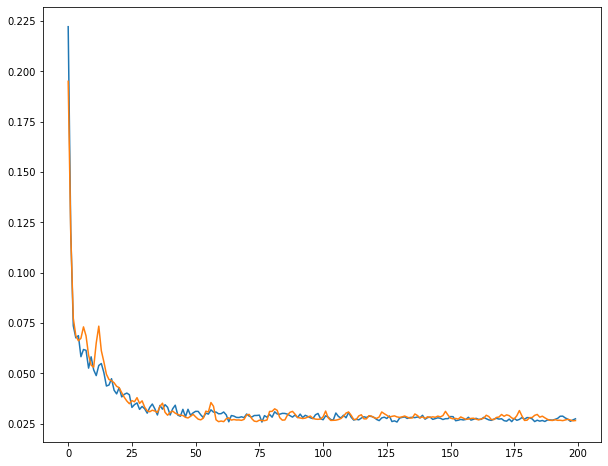

In [100]:
show_plot_lin(his)

In [102]:
his.history["val_mse"][-1]

0.02655734308063984

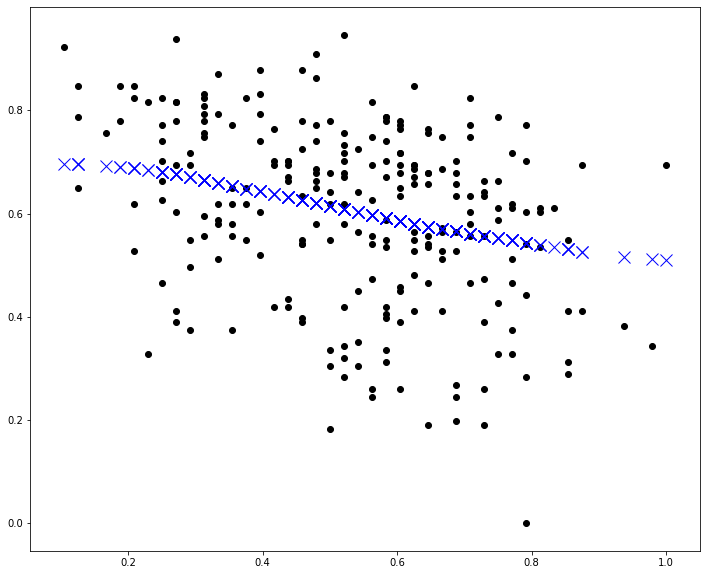

In [104]:
plt.scatter(X_train, y_train, color="black")
plt.plot(X_train, model.predict(X_train), color="blue", linestyle="None",
        marker='x', markersize=12)

## Overfitting
Many features with little training examples

In [105]:
X = df[['oldpeak', 'age', 'exang', 'ca', 'thalach']]
X = pd.get_dummies(X, columns=["exang", "ca", "thalach"])
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [107]:
def build_model():
    model = Sequential([
        ly.Dense(16, activation="relu", input_shape=[X_train.shape[1]]),
        ly.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [109]:
model = build_model()

his = model.fit(X_train, y_train, shuffle=True, epochs=500, validation_split = 0.95, batch_size=32, verbose=0)

No handles with labels found to put in legend.


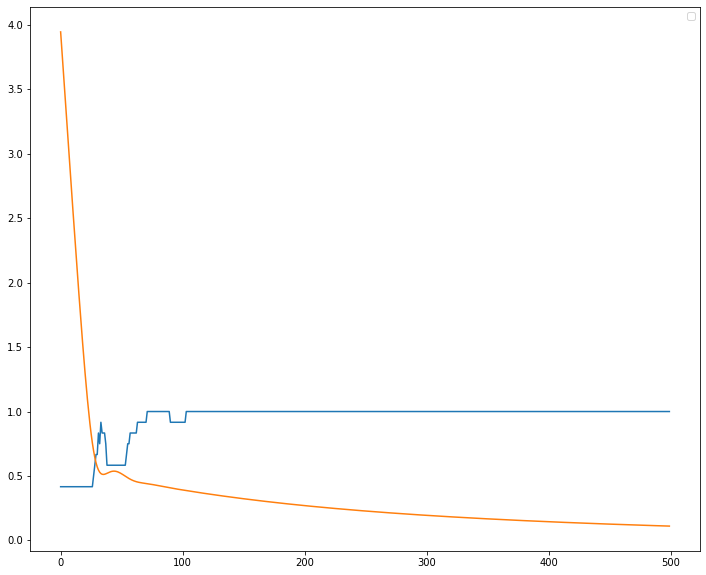

In [111]:
def show_plot(h):
    plt.plot(h.history["accuracy"])
    plt.plot(h.history["loss"])
    plt.legend()
    plt.show()
show_plot(his)

#### Fix
Add more data

In [112]:
model = build_model()

his = model.fit(X_train, y_train, shuffle=True, epochs=500, validation_split = 0.2, batch_size=32, verbose=0)

No handles with labels found to put in legend.


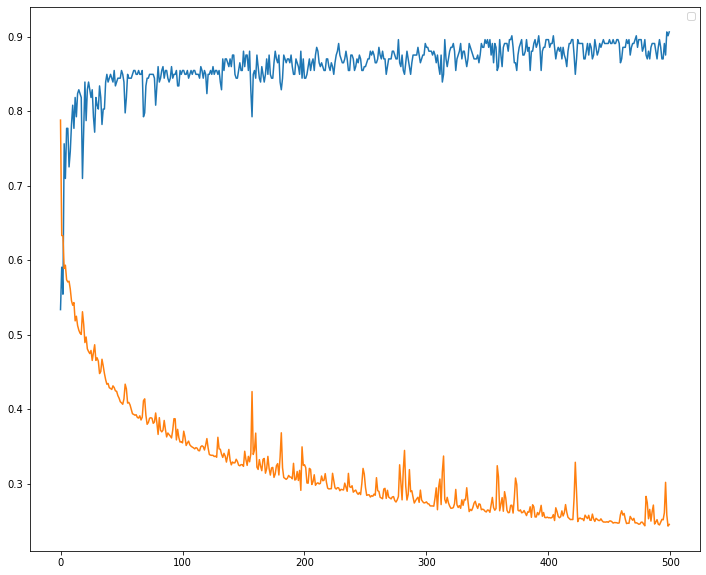

In [113]:
show_plot(his)

### Too complex model

In [114]:
def build_model():
    model = Sequential([
        ly.Dense(128, activation="relu", input_shape=[X_train.shape[1]]),
        ly.Dense(64, activation="relu"),
        ly.Dense(32, activation="relu"),
        ly.Dense(16, activation="relu"),
        ly.Dense(8, activation="relu"),
        ly.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [115]:
model = build_model()

his = model.fit(X_train, y_train, shuffle=True, epochs=200, validation_split=0.2,
               batch_size=32, verbose=0)

No handles with labels found to put in legend.


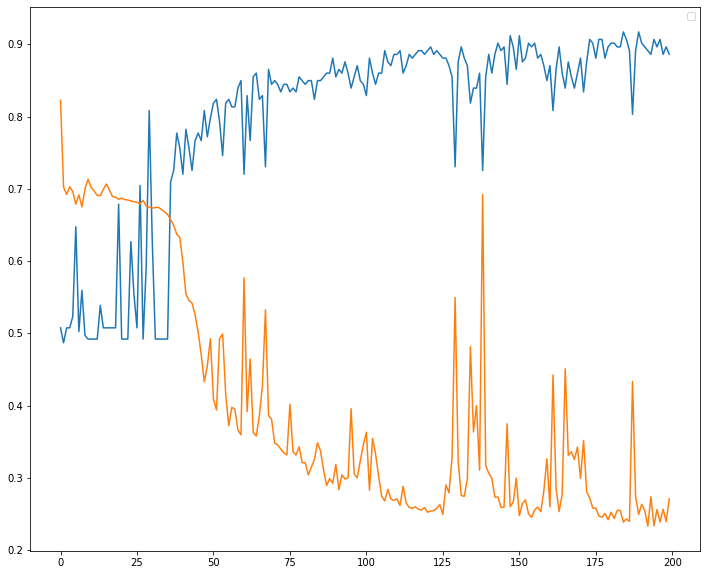

In [116]:
show_plot(his)

#### Fix 1:
Early Stopping

In [118]:
model = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=25)

his = model.fit(X_train, y_train, shuffle=True, epochs=200, validation_split=0.2,
               verbose=0, callbacks=[early_stop])

No handles with labels found to put in legend.


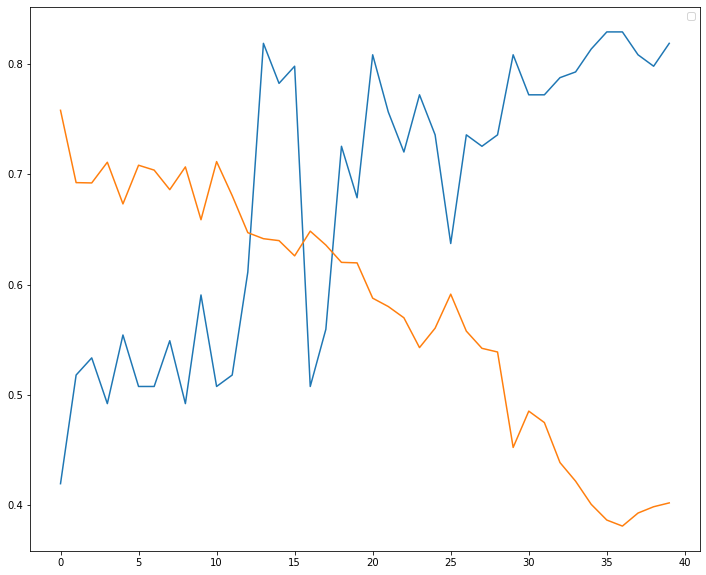

In [119]:
show_plot(his)

#### Fix 2:
Use regularization

In [126]:
model = Sequential([
    ly.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    ly.Dropout(0.2),
    ly.Dense(64, activation='relu'),
    ly.Dropout(0.2),
    ly.Dense(32, activation='relu'),
    ly.Dropout(0.2),
    ly.Dense(16, activation='relu'),
    ly.Dropout(0.2),
    ly.Dense(8, activation='relu'),
    ly.Dense(1, activation='sigmoid'),
  ])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [127]:
his = model.fit(X_train, y_train, shuffle=True, epochs=200, validation_split=0.2,
               verbose=0)

No handles with labels found to put in legend.


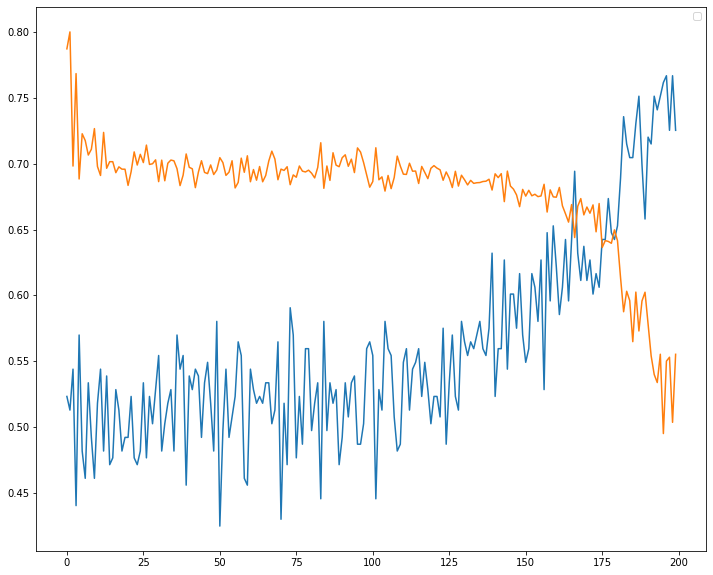

In [128]:
show_plot(his)